In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
import glob
import os

In [3]:
size=224

train_images=[]
train_labels=[]

for directory_path in glob.glob("/content/drive/MyDrive/augmented_main_images_cross_wavelet_binary/*"):
    label=directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path,"*.png")):
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(size,size))
        img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)


train_images=np.array(train_images)
train_labels=np.array(train_labels)

test_images=[]
test_labels=[]

In [4]:
for directory_path in glob.glob("/content/drive/MyDrive/val1/*"):
    fruit_label=directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path,"*.png")):
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(size,size))
        img=cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

test_images=np.array(test_images)
test_labels=np.array(test_labels)

In [5]:
test_images

array([[[[  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135],
         ...,
         [  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135]],

        [[  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135],
         ...,
         [  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135]],

        [[  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135],
         ...,
         [  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135]],

        ...,

        [[  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135],
         ...,
         [  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135]],

        [[  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135],
         ...,
         [  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135]],

        [[  0,   0, 135],
         [  0,   0, 135],
         [  0,   0, 135],
         ...,
         [  0,   0, 135],
        

In [6]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded=le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)


x_train,y_train,x_test,y_test=train_images,train_labels_encoded,test_images,test_labels_encoded

x_train,x_test=x_train/255.0,x_test/255.0

In [7]:
import seaborn as sns
from tensorflow.keras.applications.xception import Xception

resnet_model=Xception(weights='imagenet',include_top=False,input_shape=(size,size,3))

for layer in resnet_model.layers:
    layer.trainable=False

resnet_feature_extractor=resnet_model.predict(x_train)
resnet_features=resnet_feature_extractor.reshape(resnet_feature_extractor.shape[0],-1)


resnet_X=resnet_features

61/61 [==============================] - 384s 6s/step


In [8]:
resnet_X_test_feature=resnet_model.predict(x_test)
resnet_X_test_features=resnet_X_test_feature.reshape(resnet_X_test_feature.shape[0],-1)

2/2 [==============================] - 11s 3s/step


In [10]:
resnet_X.shape

(1952, 100352)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
resnet_RF=RandomForestClassifier(n_estimators=200,random_state=42)

resnet_RF.fit(resnet_X,y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
resnet_prediction_RF=resnet_RF.predict(resnet_X_test_features)
resnet_prediction_RF1=le.inverse_transform(resnet_prediction_RF)

from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(test_labels_encoded,resnet_prediction_RF))

Accuracy=  0.8478260869565217


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded,resnet_prediction_RF))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84        20
           1       0.91      0.81      0.86        26

    accuracy                           0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.86      0.85      0.85        46



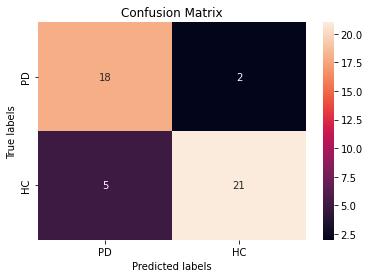

In [ ]:
from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(test_labels_encoded,resnet_prediction_RF)
ax= plt.subplot()
sns.heatmap(cm1,annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['PD', 'HC'])
ax.yaxis.set_ticklabels(['PD', 'HC']);

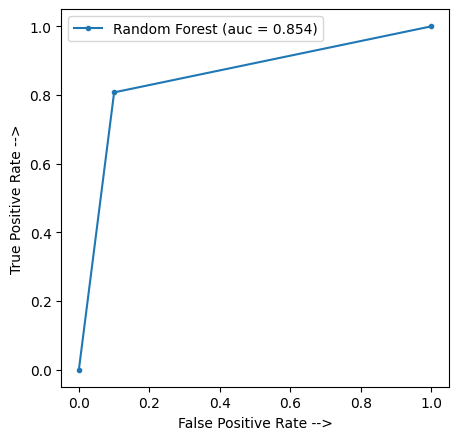

In [ ]:
from sklearn.metrics import roc_curve, auc

RF_fpr, RF_tpr, threshold = roc_curve(test_labels_encoded, resnet_prediction_RF)
auc_RF = auc(RF_fpr, RF_tpr)


plt.figure(figsize=(5, 5), dpi=100)

plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest (auc = %0.3f)' % auc_RF)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [ ]:
from sklearn.svm import SVC
resnet_SF=SVC(kernel='rbf',C=13,probability=True)
resnet_SF.fit(resnet_X,y_train)

resnet_prediction_SF=resnet_SF.predict(resnet_X_test_features)
resnet_prediction_SF1=le.inverse_transform(resnet_prediction_SF)

from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(test_labels_encoded,resnet_prediction_SF))

Accuracy=  0.8913043478260869


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded,resnet_prediction_SF))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.92      0.88      0.90        26

    accuracy                           0.89        46
   macro avg       0.89      0.89      0.89        46
weighted avg       0.89      0.89      0.89        46



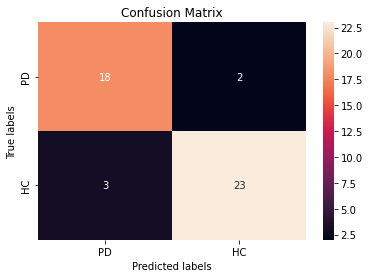

In [ ]:
from sklearn.metrics import confusion_matrix
cm1=confusion_matrix(test_labels_encoded,resnet_prediction_SF)
ax=plt.subplot()
sns.heatmap(cm1,annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['PD', 'HC'])
ax.yaxis.set_ticklabels(['PD', 'HC']);

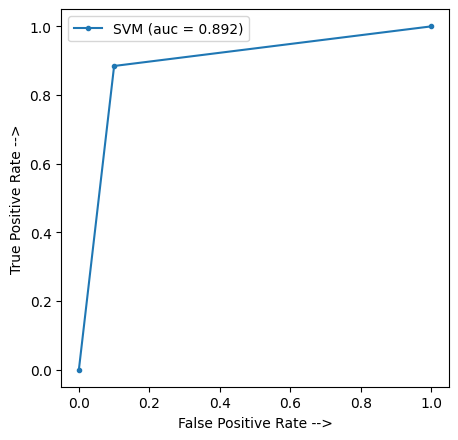

In [ ]:
from sklearn.metrics import roc_curve, auc

SF_fpr, SF_tpr, threshold = roc_curve(test_labels_encoded, resnet_prediction_SF)
auc_SF = auc(SF_fpr, SF_tpr)


plt.figure(figsize=(5, 5), dpi=100)

plt.plot(SF_fpr, SF_tpr, marker='.', label='SVM (auc = %0.3f)' % auc_SF)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
resnet_LF=LogisticRegression()
resnet_LF.fit(resnet_X,y_train)

resnet_prediction_LF=resnet_LF.predict(resnet_X_test_features)
resnet_prediction_LF1=le.inverse_transform(resnet_prediction_LF)

from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(test_labels_encoded,resnet_prediction_LF))

Accuracy=  0.9347826086956522


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded,resnet_prediction_LF))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       1.00      0.88      0.94        26

    accuracy                           0.93        46
   macro avg       0.93      0.94      0.93        46
weighted avg       0.94      0.93      0.94        46



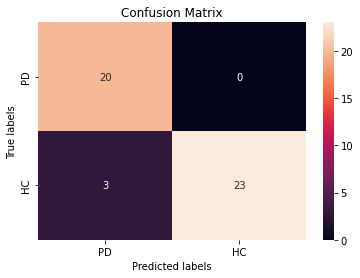

In [ ]:
cm2=confusion_matrix(test_labels_encoded,resnet_prediction_LF)
ax=plt.subplot()
sns.heatmap(cm2,annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['PD', 'HC'])
ax.yaxis.set_ticklabels(['PD', 'HC']);

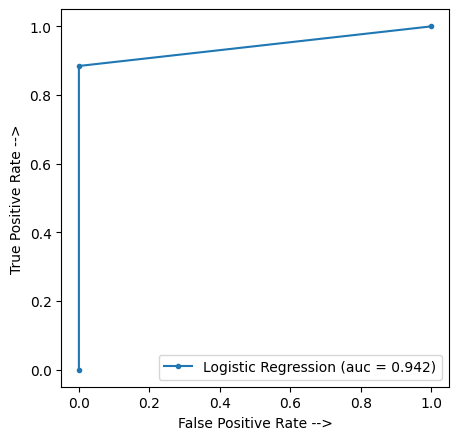

In [ ]:
from sklearn.metrics import roc_curve, auc

LF_fpr, LF_tpr, threshold = roc_curve(test_labels_encoded, resnet_prediction_LF)
auc_LF = auc(LF_fpr, LF_tpr)


plt.figure(figsize=(5, 5), dpi=100)

plt.plot(LF_fpr, LF_tpr, marker='.', label='Logistic Regression (auc = %0.3f)' % auc_LF)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
resnet_knn=KNeighborsClassifier(n_neighbors=8,weights='uniform',algorithm='brute',metric='minkowski')
resnet_knn.fit(resnet_X,y_train)
resnet_prediction_knn=resnet_knn.predict(resnet_X_test_features)
resnet_prediction_knn1=le.inverse_transform(resnet_prediction_knn)
from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(test_labels_encoded,resnet_prediction_knn))

Accuracy=  0.8478260869565217


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded,resnet_prediction_knn))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81        20
           1       0.83      0.92      0.87        26

    accuracy                           0.85        46
   macro avg       0.85      0.84      0.84        46
weighted avg       0.85      0.85      0.85        46



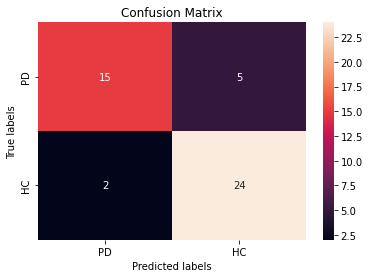

In [ ]:
cm2=confusion_matrix(test_labels_encoded,resnet_prediction_knn)
ax=plt.subplot()
sns.heatmap(cm2,annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['PD', 'HC'])
ax.yaxis.set_ticklabels(['PD', 'HC']);

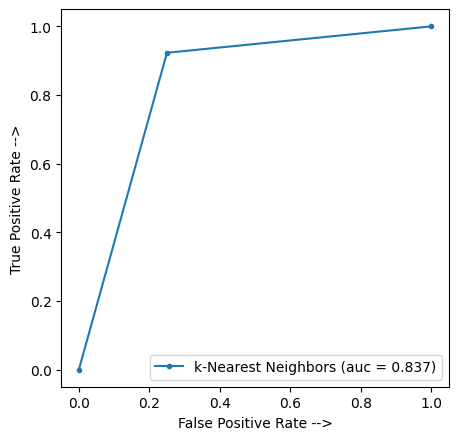

In [ ]:
from sklearn.metrics import roc_curve, auc

knn_fpr, knn_tpr, threshold = roc_curve(test_labels_encoded, resnet_prediction_knn)
auc_knn = auc(knn_fpr, knn_tpr)


plt.figure(figsize=(5, 5), dpi=100)

plt.plot(knn_fpr, knn_tpr, marker='.', label='k-Nearest Neighbors (auc = %0.3f)' % auc_knn)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf1=VotingClassifier(
                            estimators=[('rf',resnet_RF),('svc',resnet_SF),('lr',resnet_LF)],
                            voting='soft'
)

voting_clf2=VotingClassifier(
                            estimators=[('svc',resnet_SF),('lr',resnet_LF),('knn',resnet_knn),('rf',resnet_RF)],
                            voting='hard'
)

In [ ]:
voting_clf1.fit(resnet_X,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('svc', SVC(C=13, probability=True)),
                             ('lr', LogisticRegression())],
                 voting='soft')

In [ ]:
resnet_prediction_softVoting=voting_clf1.predict(resnet_X_test_features)
resnet_prediction_softVoting1=le.inverse_transform(resnet_prediction_softVoting)
from sklearn import metrics
print("Accuracy= ",metrics.accuracy_score(test_labels_encoded,resnet_prediction_softVoting))

Accuracy=  0.9347826086956522


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded,resnet_prediction_softVoting))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       1.00      0.88      0.94        26

    accuracy                           0.93        46
   macro avg       0.93      0.94      0.93        46
weighted avg       0.94      0.93      0.94        46



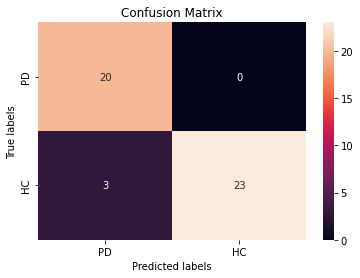

In [ ]:
cm6=confusion_matrix(test_labels_encoded,resnet_prediction_softVoting)
ax=plt.subplot()
sns.heatmap(cm6,annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['PD', 'HC'])
ax.yaxis.set_ticklabels(['PD', 'HC']);

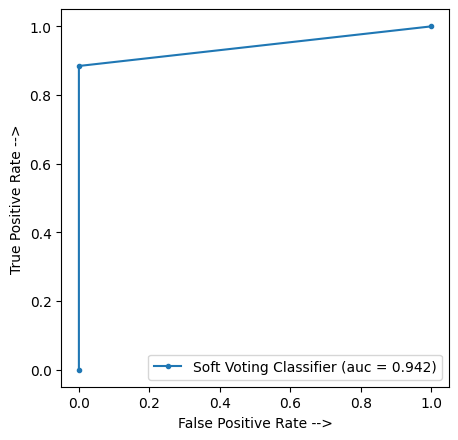

In [ ]:
from sklearn.metrics import roc_curve, auc

SoftVoting_fpr, SoftVoting_tpr, threshold = roc_curve(test_labels_encoded, resnet_prediction_softVoting)
auc_SoftVoting = auc(SoftVoting_fpr, SoftVoting_tpr)


plt.figure(figsize=(5, 5), dpi=100)

plt.plot(SoftVoting_fpr, SoftVoting_tpr, marker='.', label='Soft Voting Classifier (auc = %0.3f)' % auc_SoftVoting)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()